In [2]:
# Core Libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
from warnings import filterwarnings

# Stats & Visualization
import statsmodels.api as sm  # fixed from 'import statsmodels as sm'

# Preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, MinMaxScaler

# Model Selection
from sklearn.model_selection import (
    train_test_split, cross_val_score, cross_val_predict,
    learning_curve, cross_validate, GridSearchCV
)

# Dimensionality Reduction
from sklearn.decomposition import PCA, FactorAnalysis

# Models
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import RidgeClassifier, SGDClassifier, ElasticNet
from sklearn.tree import ExtraTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier

# Ensemble Models
from sklearn.ensemble import (
    RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier,
    BaggingClassifier, GradientBoostingClassifier
)

# Feature Selection
from sklearn.feature_selection import SelectFromModel

# Pipelines
from sklearn.pipeline import Pipeline

# Metrics
from sklearn.metrics import (
    roc_auc_score, precision_score, recall_score,
    ConfusionMatrixDisplay  # use this instead of deprecated plot_confusion_matrix
)

# XGBoost (needs to be installed)
try:
    from xgboost import XGBClassifier, XGBRFClassifier, plot_importance
except ImportError:
    print("Warning: XGBoost not installed. Use `pip install xgboost`")

# Imbalanced-learn tools (needs to be installed)
try:
    from imblearn.combine import SMOTEENN
    from imblearn.metrics import classification_report_imbalanced, geometric_mean_score
    from imblearn.pipeline import make_pipeline
    from imblearn.ensemble import (
        RUSBoostClassifier, BalancedRandomForestClassifier,
        BalancedBaggingClassifier, EasyEnsembleClassifier
    )
except ImportError:
    print("Warning: imbalanced-learn not installed. Use `pip install imbalanced-learn`")

# Deep Learning (optional, needs to be installed)
try:
    from keras import Sequential, layers, Input, callbacks, utils, regularizers
    import tensorflow as tf
except ImportError:
    print("Warning: Keras/TensorFlow not installed. Use `pip install keras tensorflow`")

filterwarnings('ignore')

In [3]:
plt.style.use('fivethirtyeight')
sns.set_style('whitegrid')
filterwarnings('ignore')

In [4]:
file = 'predictive_maintenance.csv'

In [5]:
maintenance = pd.read_csv(file)

In [6]:
maintenance.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure


In [7]:
maintenance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Target                   10000 non-null  int64  
 9   Failure Type             10000 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 781.4+ KB


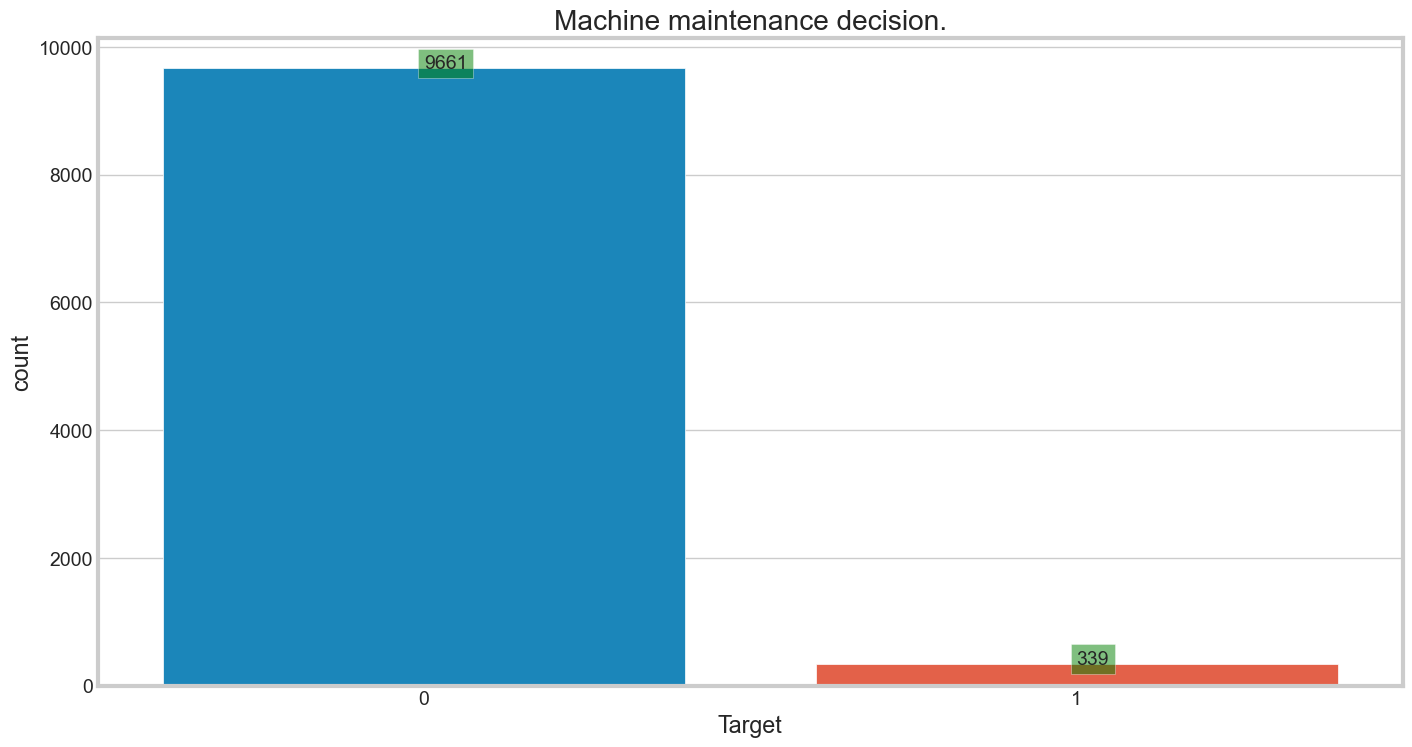

In [8]:
plt.figure(figsize=(15,8))
g=sns.countplot(x='Target', data=maintenance)
for i, u in enumerate(maintenance['Target'].value_counts().values):
    g.text(i, u, str(u), bbox=dict(facecolor='green', alpha=0.5))
plt.title('Machine maintenance decision.')
plt.show()

In [9]:
maintenance.drop(columns=['UDI',], inplace=True)

In [10]:
maintenance.describe()

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900
std,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981
min,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000
25%,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000
50%,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000
75%,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000
max,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000


In [13]:
maintenance_numeric = maintenance.select_dtypes(include='number')
maintenance_numeric.corr()

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target
Air temperature [K],1.000000,0.876107,0.022670,-0.013778,0.013853,0.082556
Process temperature [K],0.876107,1.000000,0.019277,-0.014061,0.013488,0.035946
Rotational speed [rpm],0.022670,0.019277,1.000000,-0.875027,0.000223,-0.044188
Torque [Nm],-0.013778,-0.014061,-0.875027,1.000000,-0.003093,0.191321
Tool wear [min],0.013853,0.013488,0.000223,-0.003093,1.000000,0.105448
Target,0.082556,0.035946,-0.044188,0.191321,0.105448,1.000000


In [15]:
maintenance_numeric.skew()

Air temperature [K]        0.114274
Process temperature [K]    0.015027
Rotational speed [rpm]     1.993171
Torque [Nm]               -0.009517
Tool wear [min]            0.027292
Target                     5.151852
dtype: float64

In [16]:
maintenance_numeric.kurtosis()

Air temperature [K]        -0.835962
Process temperature [K]    -0.499734
Rotational speed [rpm]      7.392945
Torque [Nm]                -0.013241
Tool wear [min]            -1.166737
Target                     24.546486
dtype: float64

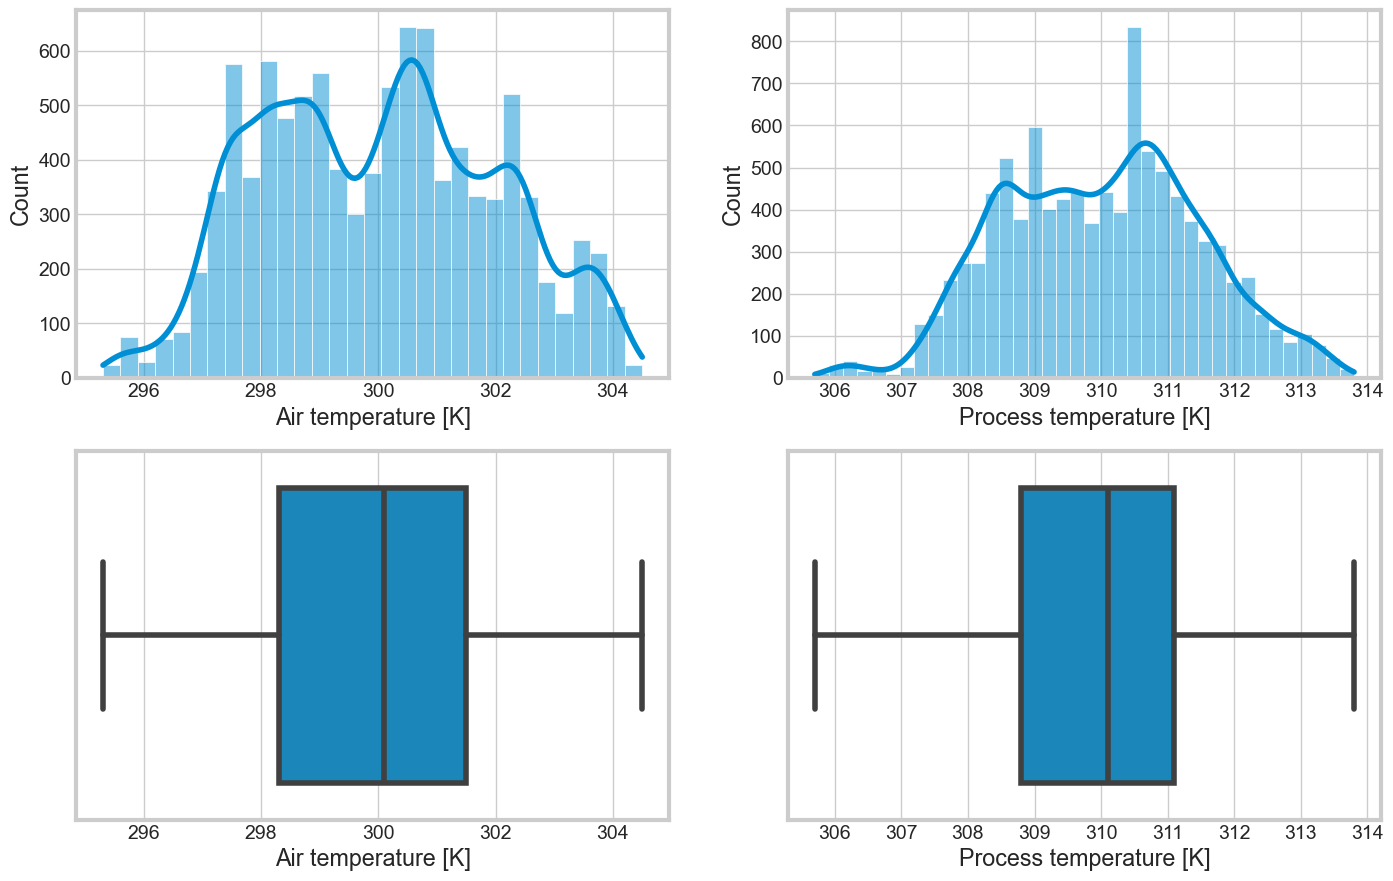

In [17]:
fig, ax = plt.subplots(2, 2, figsize=(15,10))
sns.histplot(data=maintenance, x='Air temperature [K]', kde=True, ax=ax[0,0])
sns.histplot(data=maintenance, x='Process temperature [K]', kde=True, ax=ax[0,1])
sns.boxplot(data=maintenance, x='Air temperature [K]', ax=ax[1,0])
sns.boxplot(data=maintenance, x='Process temperature [K]', ax=ax[1,1])
plt.show()

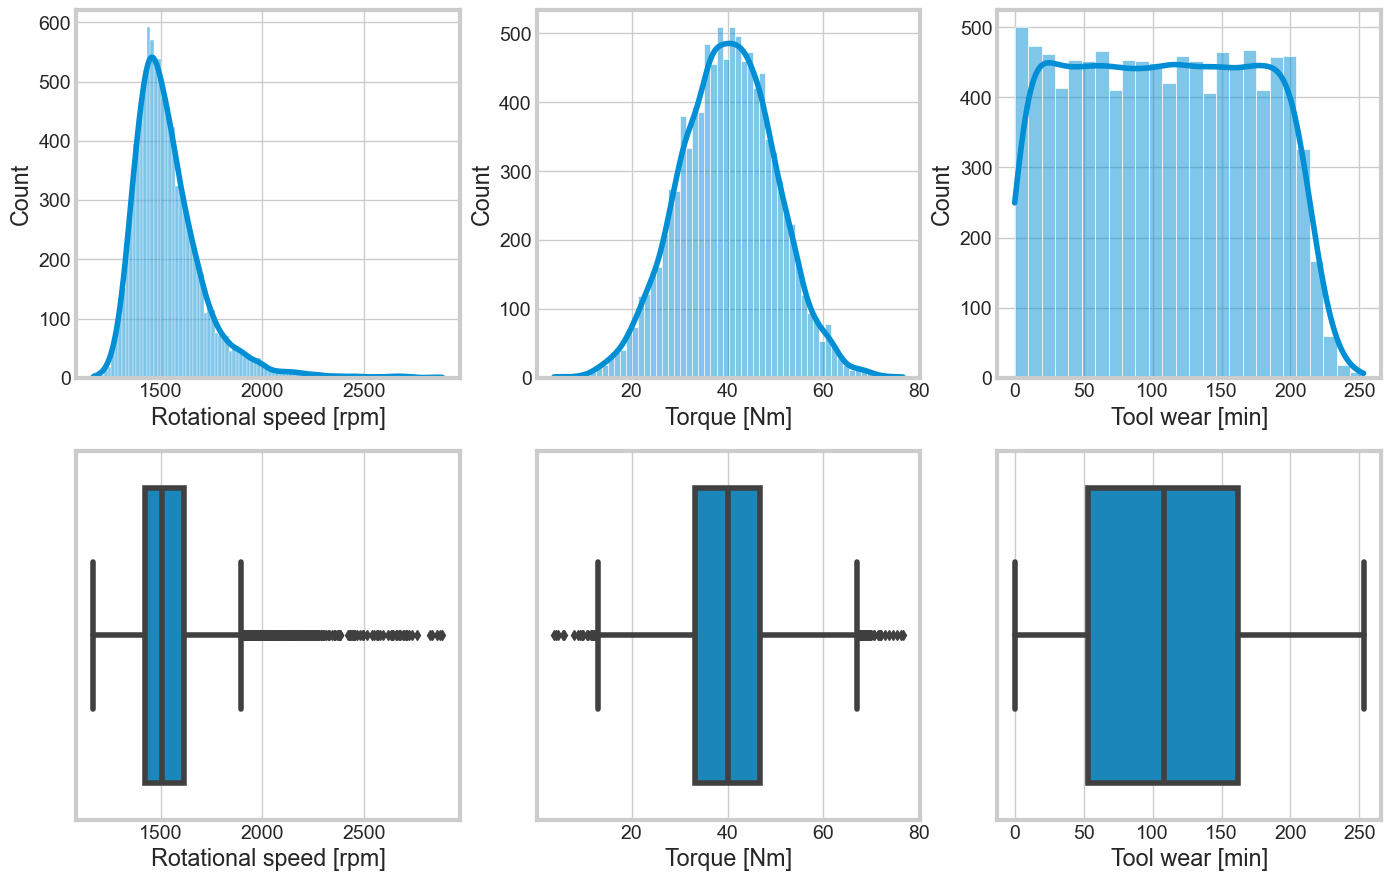

In [18]:
fig1, ax1 = plt.subplots(2, 3, figsize=(15,10))
sns.histplot(data=maintenance, x='Rotational speed [rpm]', kde=True, ax=ax1[0,0])
sns.histplot(data=maintenance, x='Torque [Nm]', kde=True, ax=ax1[0,1])
sns.histplot(data=maintenance, x='Tool wear [min]', kde=True, ax=ax1[0,2])
sns.boxplot(data=maintenance, x='Rotational speed [rpm]', ax=ax1[1,0])
sns.boxplot(data=maintenance, x='Torque [Nm]', ax=ax1[1,1])
sns.boxplot(data=maintenance, x='Tool wear [min]', ax=ax1[1,2])
plt.show()

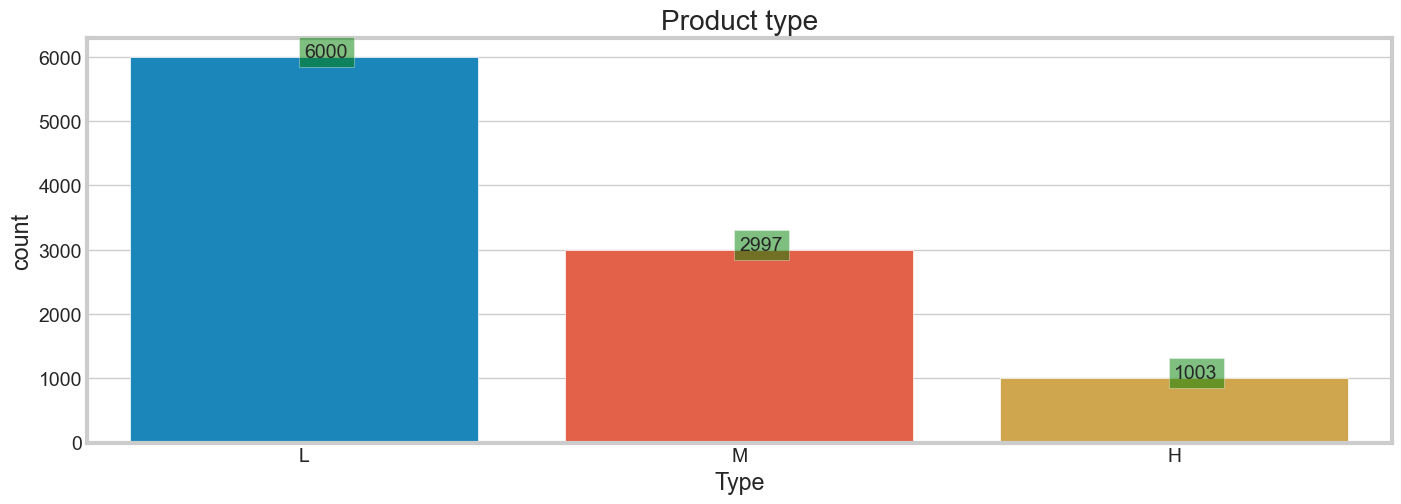

In [19]:
plt.figure(figsize=(15,5))
h=sns.countplot(x='Type', data=maintenance, order=['L','M','H'])
for i, u in enumerate(maintenance['Type'].value_counts().values):
    h.text(i, u, str(u), bbox=dict(facecolor='green', alpha=0.5))
plt.title('Product type')
plt.show()

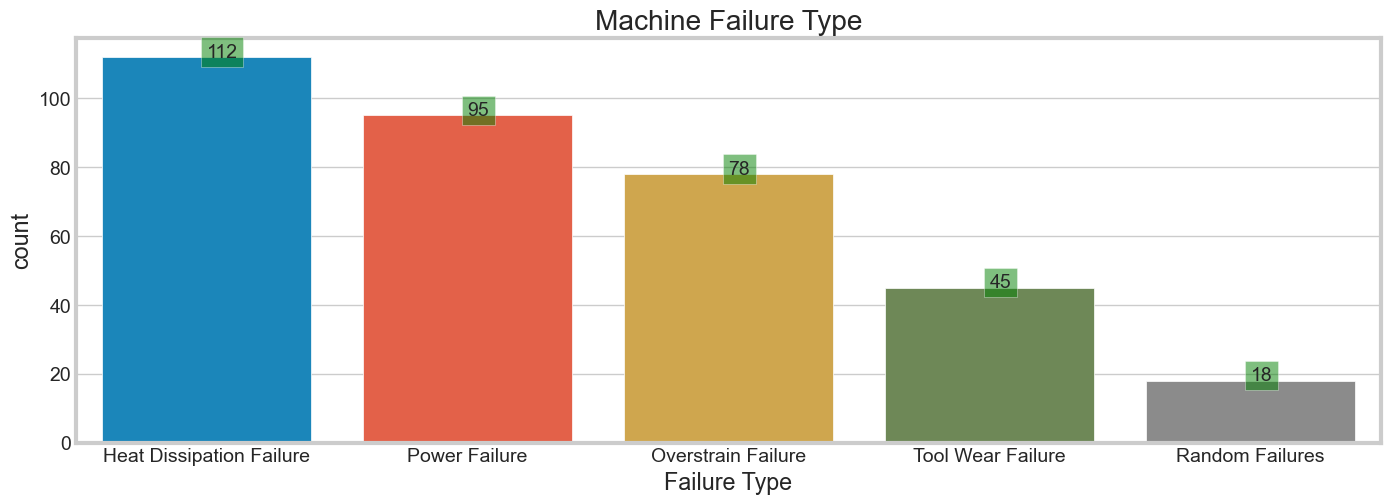

In [20]:
plt.figure(figsize=(15,5))
machine_failure = maintenance[maintenance['Failure Type'] != 'No Failure']
hg=sns.countplot(x='Failure Type', data=machine_failure, order=['Heat Dissipation Failure', 'Power Failure',
                                                              'Overstrain Failure', 'Tool Wear Failure',
                                                              'Random Failures'])
for i, u in enumerate(machine_failure['Failure Type'].value_counts().values):
    hg.text(i, u, str(u), bbox=dict(facecolor='green', alpha=0.5))
plt.title('Machine Failure Type')
plt.show()

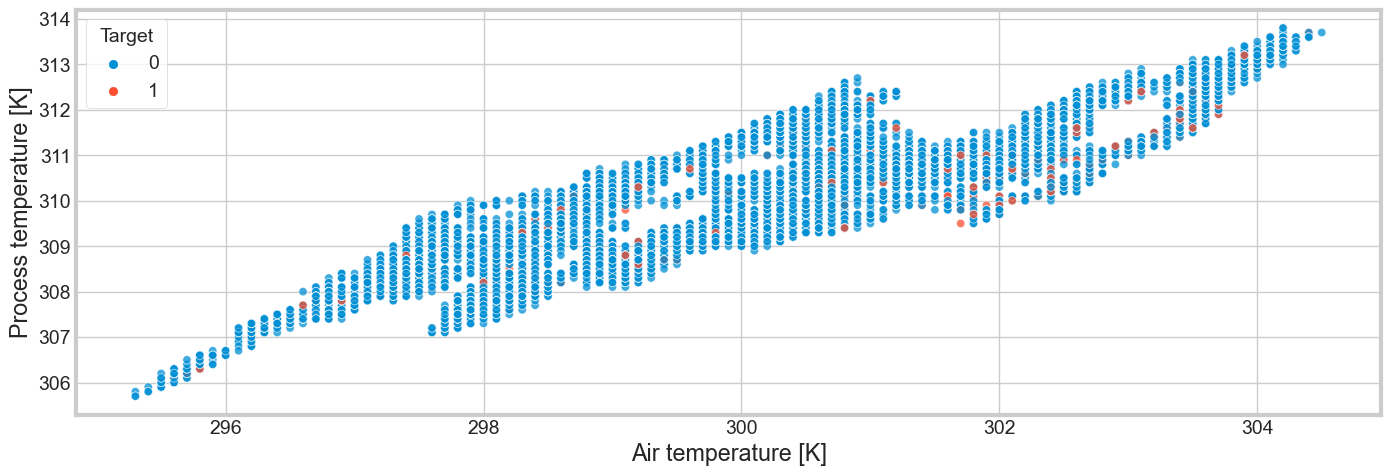

In [21]:
plt.figure(figsize=(15,5))
sns.scatterplot(x='Air temperature [K]', y='Process temperature [K]',
            hue='Target', alpha=0.75, data=maintenance)
#plt.xlabel('Air temperature [K]')
#plt.ylabel('Process temperature [K]')
plt.show()

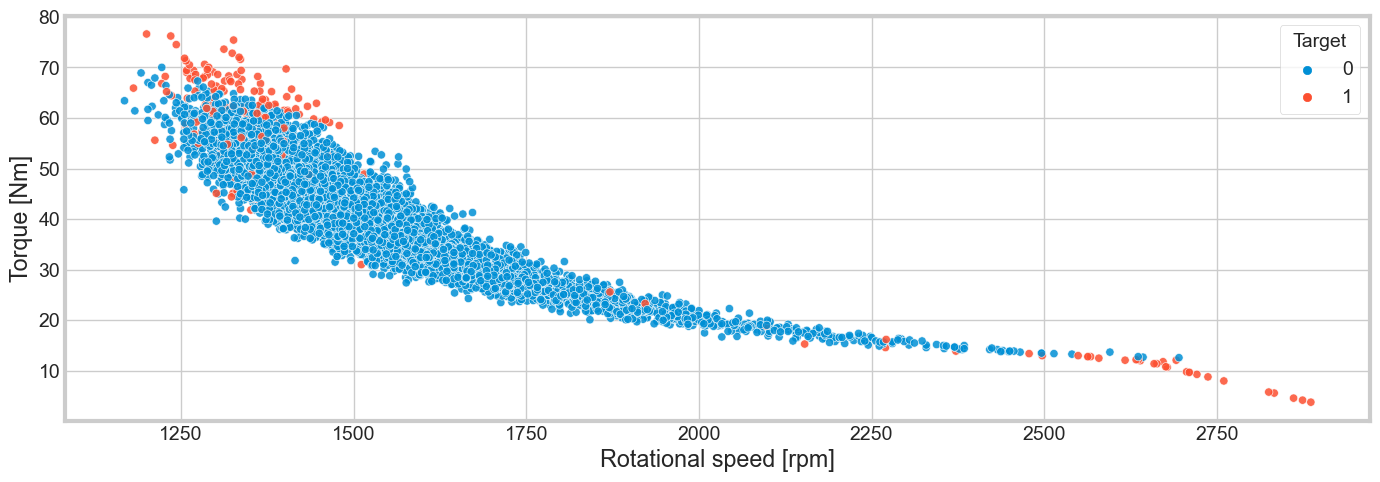

In [22]:
plt.figure(figsize=(15,5))
sns.scatterplot(x='Rotational speed [rpm]', y='Torque [Nm]', hue='Target', alpha=0.85, data=maintenance)
plt.show()

In [23]:
maintenance['Power [W]'] = maintenance['Torque [Nm]']*(2*np.pi*maintenance['Rotational speed [rpm]']/60.0)
maintenance['Overstrain [minNm]'] = maintenance['Torque [Nm]'] * maintenance['Tool wear [min]']
maintenance['Heat dissipation [rpminK]'] = abs(maintenance['Air temperature [K]'] -maintenance['Process temperature [K]'])*maintenance['Rotational speed [rpm]']

In [24]:
maintenance.tail(3)

,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type,Power [W],Overstrain [minNm],Heat dissipation [rpminK]
9997,M24857,M,299.0,308.6,1645,33.4,22,0,No Failure,5753.617506,734.8,15792.0
9998,H39412,H,299.0,308.7,1408,48.5,25,0,No Failure,7151.102638,1212.5,13657.6
9999,M24859,M,299.0,308.7,1500,40.2,30,0,No Failure,6314.601234,1206.0,14550.0


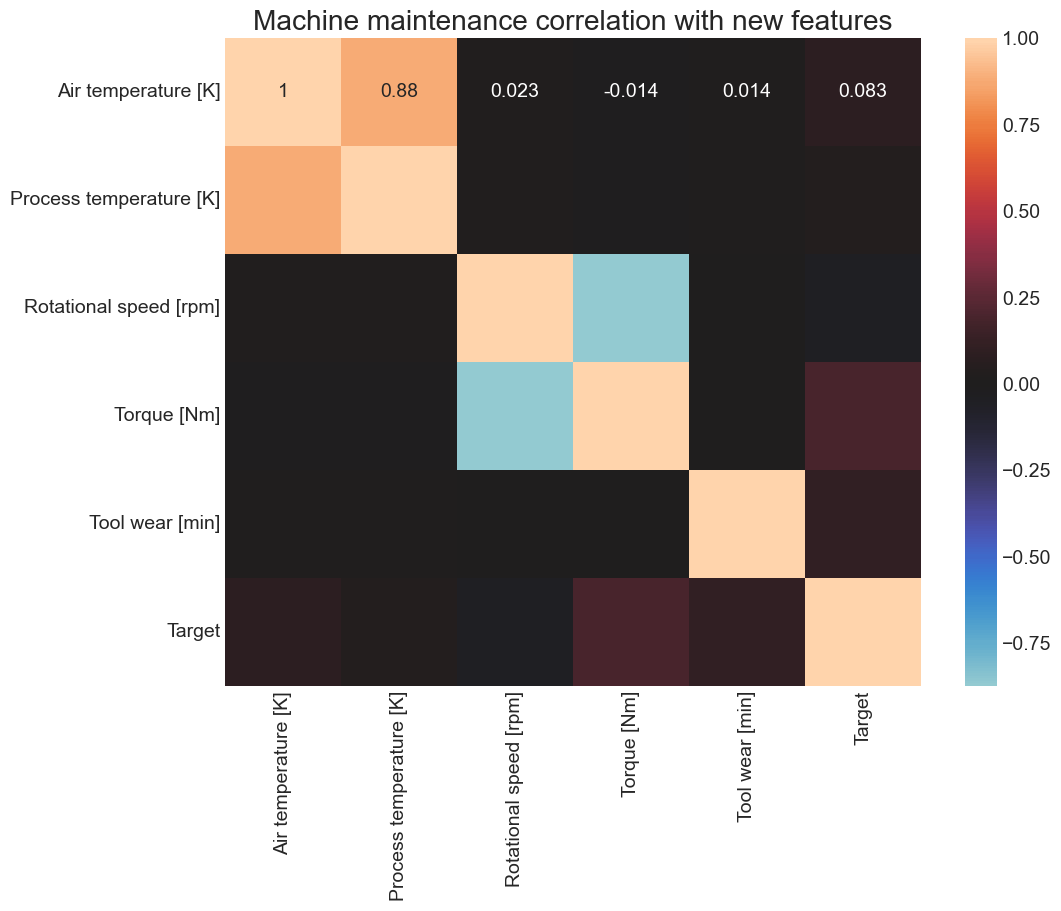

In [26]:
plt.figure(figsize=(10,8))
sns.heatmap(maintenance_numeric.corr(), annot=True, center=0)
plt.title('Machine maintenance correlation with new features')
plt.show()

In [27]:
maintenance[['Power [W]', 'Overstrain [minNm]', 'Heat dissipation [rpminK]']].describe()

,Power [W],Overstrain [minNm],Heat dissipation [rpminK]
count,10000.000000,10000.000000,10000.000000
mean,6279.744953,4314.664550,15385.728570
std,1067.418295,2826.567692,2343.469423
min,1148.440610,0.000000,9851.400000
25%,5561.184484,1963.650000,13740.800000
50%,6271.027344,4012.950000,15150.000000
75%,7003.002724,6279.000000,16712.475000
max,10469.923005,16497.000000,32476.200000


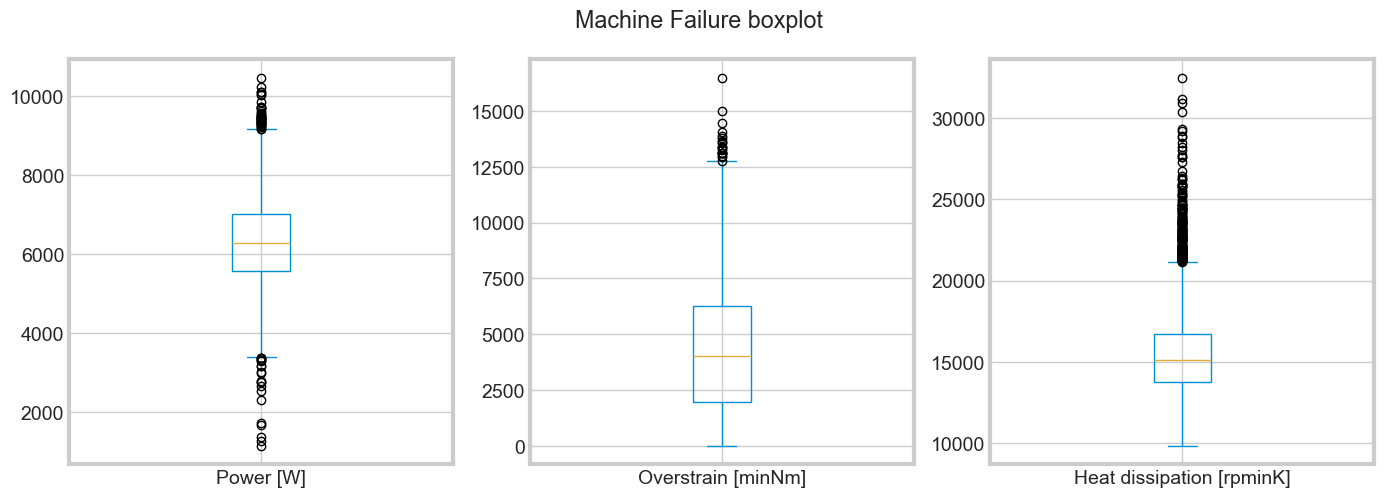

In [28]:
maintenance[['Power [W]', 'Overstrain [minNm]', 'Heat dissipation [rpminK]']].plot.box(subplots=True,
                                                                                      figsize=(15,5))
plt.suptitle('Machine Failure boxplot')
plt.show()

In [29]:
power = maintenance[maintenance['Failure Type'].isin(['Power Failure', 'Random Failures'])]
overstrain = maintenance[maintenance['Failure Type'].isin(['Overstrain Failure', 'Random Failures'])]
heat_dissipation = maintenance[maintenance['Failure Type'].isin(['Heat Dissipation Failure', 'Random Failures'])]
tool_wear = maintenance[maintenance['Failure Type'].isin(['Tool Wear Failure', 'Random Failures'])]

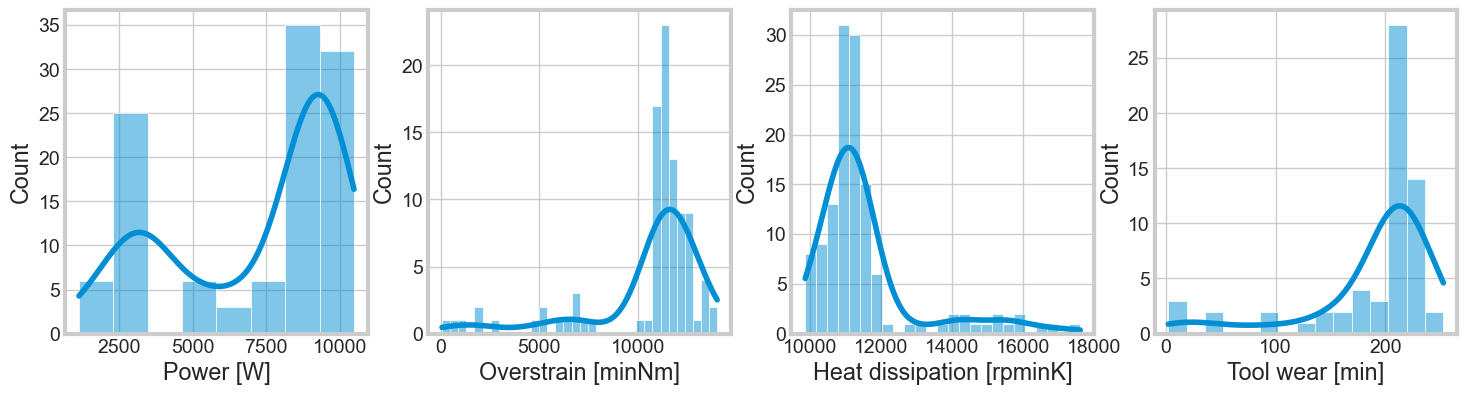

In [30]:
_, ax2 = plt.subplots(1, 4, figsize=(16,4))
sns.histplot(x='Power [W]',data=power, kde=True, ax=ax2[0])
sns.histplot(x='Overstrain [minNm]',data=overstrain, kde=True, ax=ax2[1])
sns.histplot(x='Heat dissipation [rpminK]', data=heat_dissipation, ax=ax2[2], kde=True)
sns.histplot(x='Tool wear [min]', data=tool_wear, ax=ax2[3], kde=True)
plt.show()

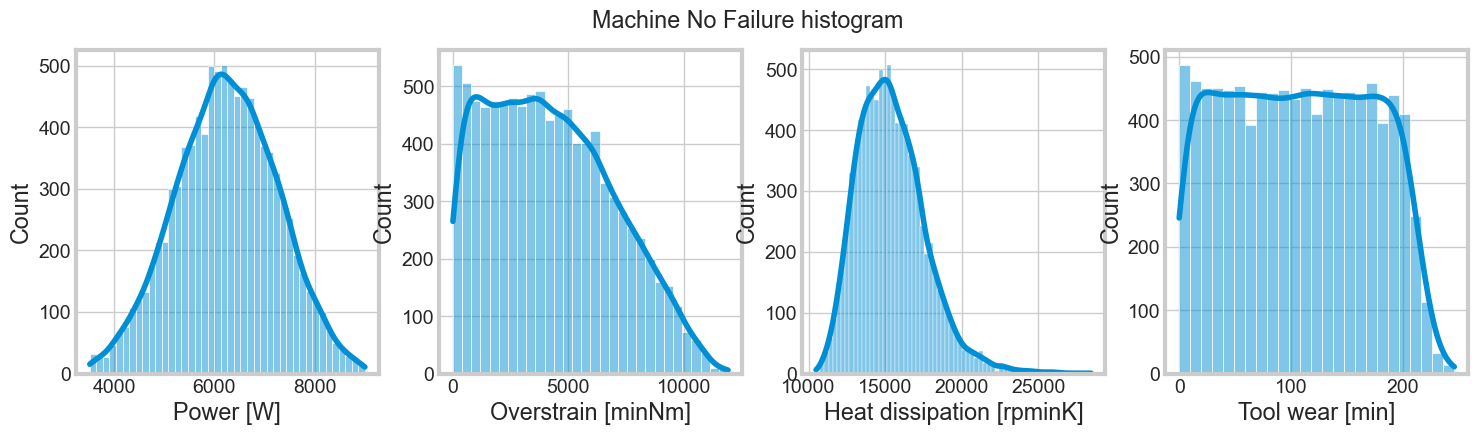

In [31]:
_, ax3 = plt.subplots(1, 4, figsize=(16,4))
df = maintenance[maintenance['Failure Type'] == 'No Failure']
sns.histplot(x='Power [W]',data=df  , kde=True, ax=ax3[0])
sns.histplot(x='Overstrain [minNm]',data=df, kde=True, ax=ax3[1])
sns.histplot(x='Heat dissipation [rpminK]', data=df, ax=ax3[2], kde=True)
sns.histplot(x='Tool wear [min]', data=df, ax=ax3[3], kde=True)
plt.suptitle('Machine No Failure histogram')
plt.show()

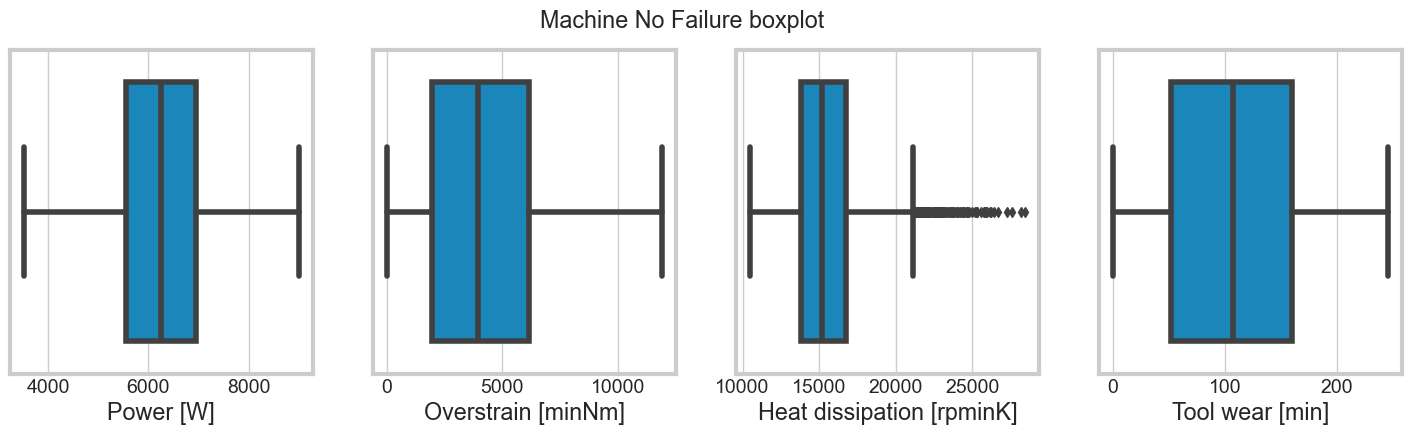

In [32]:
_, ax4  = plt.subplots(1, 4, figsize=(16,4))
sns.boxplot(x='Power [W]',data=df , ax=ax4[0])
sns.boxplot(x='Overstrain [minNm]', data=df, ax=ax4[1])
sns.boxplot(x='Heat dissipation [rpminK]', data=df, ax=ax4[2])
sns.boxplot(x='Tool wear [min]', data=df, ax=ax4[3])
plt.suptitle('Machine No Failure boxplot')
plt.show()

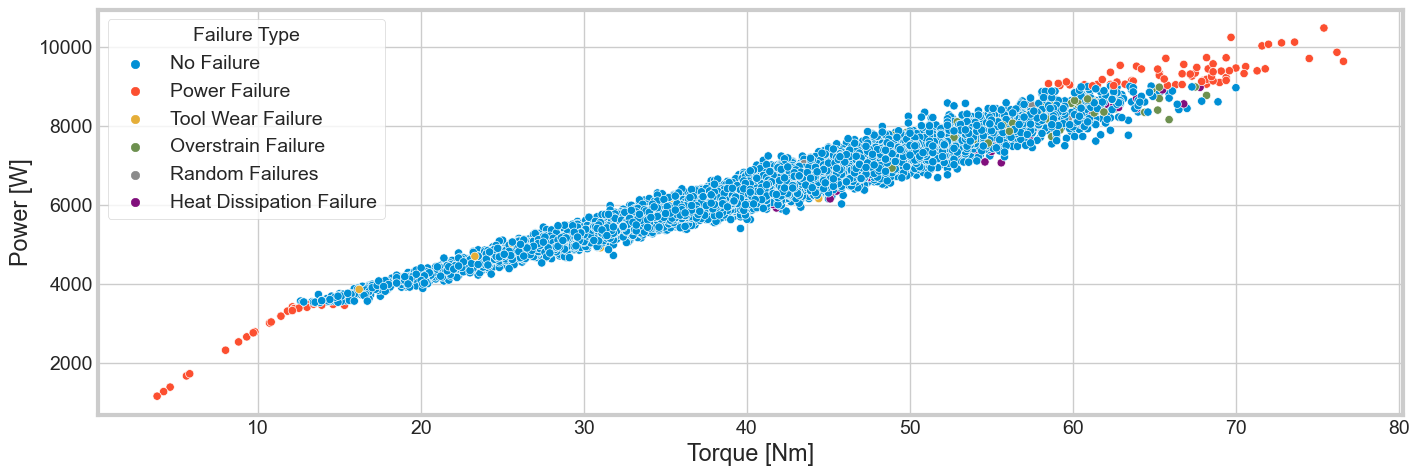

In [33]:
plt.figure(figsize=(15, 5))
sns.scatterplot(y='Power [W]', x='Torque [Nm]', hue='Failure Type', data=maintenance)
plt.show()

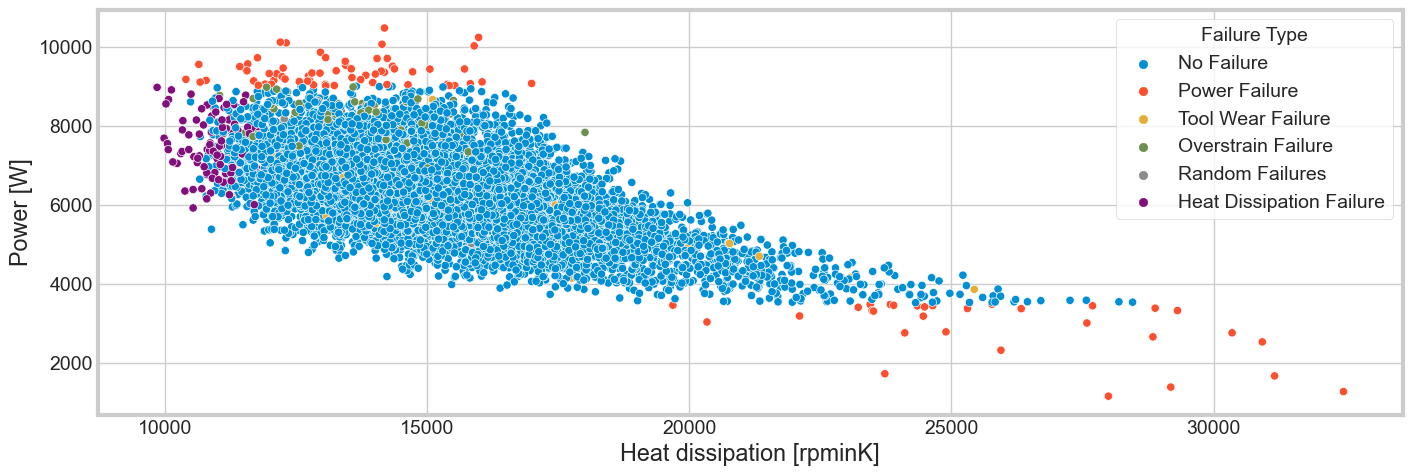

In [34]:
plt.figure(figsize=(15, 5))
sns.scatterplot(y='Power [W]', x='Heat dissipation [rpminK]', hue='Failure Type', data=maintenance)
plt.show()

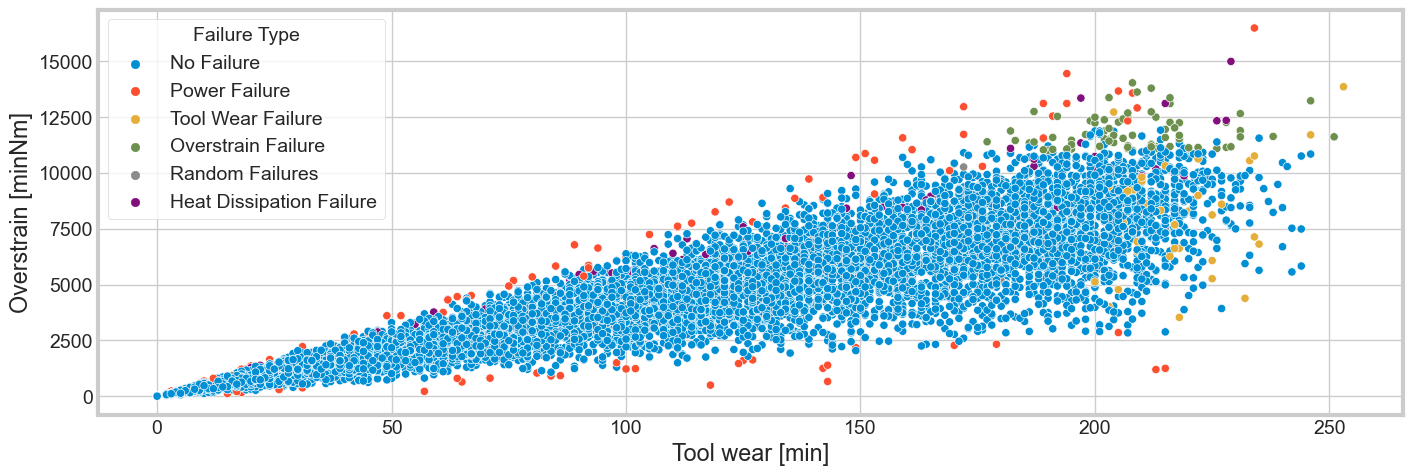

In [35]:
plt.figure(figsize=(15, 5))
sns.scatterplot(y='Overstrain [minNm]', x='Tool wear [min]', hue='Failure Type', data=maintenance)
plt.show()

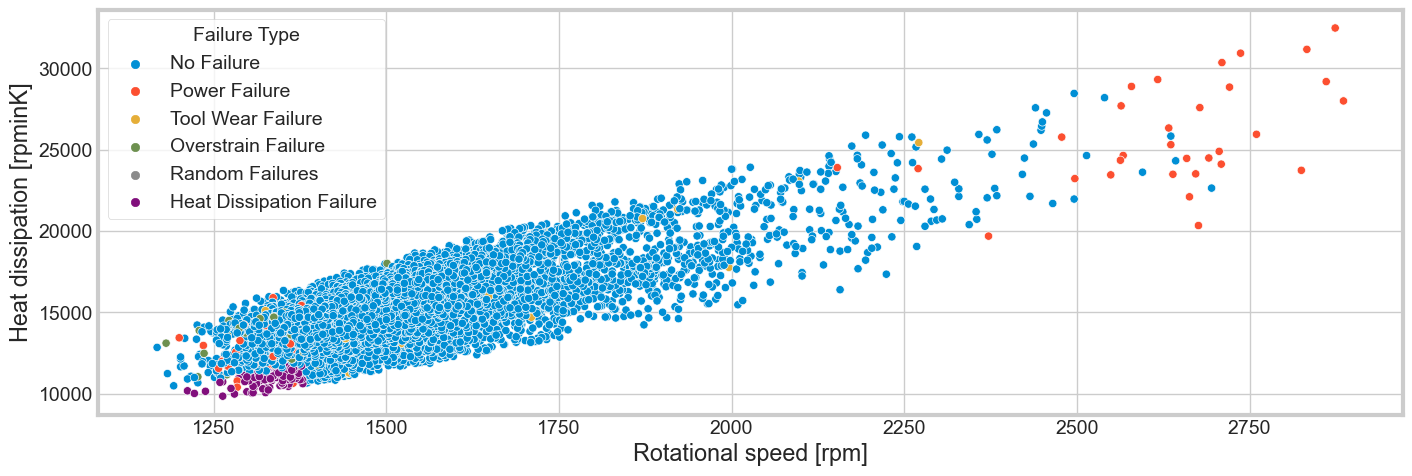

In [36]:
plt.figure(figsize=(15, 5))
sns.scatterplot(x='Rotational speed [rpm]', y='Heat dissipation [rpminK]', hue='Failure Type', data=maintenance)
plt.show()

In [37]:
data =  maintenance.drop(columns=['Product ID','Type', 'Failure Type'])

In [38]:
matcorr = data.corr()
vif = pd.Series(np.linalg.inv(matcorr.to_numpy()).diagonal(), index=data.columns, name='vif_factor' )

In [39]:
vif.reset_index()

,index,vif_factor
0,Air temperature [K],304.072060
1,Process temperature [K],169.021051
2,Rotational speed [rpm],102.292324
3,Torque [Nm],56.428329
4,Tool wear [min],17.202630
5,Target,1.241797
6,Power [W],34.412315
7,Overstrain [minNm],20.172133
8,Heat dissipation [rpminK],172.729158


In [40]:
cols_selected = ['Process temperature [K]', 'Torque [Nm]', 'Tool wear [min]']

In [41]:
# We compute new vif
matcorr_ = data[cols_selected].corr()
vif_ = pd.Series(np.linalg.inv(matcorr_.to_numpy()).diagonal(), index=matcorr_.columns, name='vif_factor' )

In [42]:
vif_.reset_index()

,index,vif_factor
0,Process temperature [K],1.000379
1,Torque [Nm],1.000206
2,Tool wear [min],1.000190


In [43]:
Xdata = data[cols_selected] #
target = maintenance['Target'] #

In [45]:
xtrain, xtest, ytrain, ytest = train_test_split(Xdata, target, stratify=target, random_state=0, test_size=0.2)

In [46]:
print(f'Xtrain shape: {xtrain.shape} ytrain shape: {ytrain.shape}.')

Xtrain shape: (8000, 3) ytrain shape: (8000,).


In [49]:
from imblearn.ensemble import (
    BalancedBaggingClassifier, RUSBoostClassifier,
    BalancedRandomForestClassifier, EasyEnsembleClassifier
)
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score
from imblearn.metrics import geometric_mean_score

def ensemble_sampler_learning(X, y):
    # Updated estimators
    ens_learners = {
        'bagg': BalancedBaggingClassifier(estimator=ExtraTreesClassifier(), random_state=0, n_jobs=-1),
        'rus': RUSBoostClassifier(estimator=ExtraTreesClassifier(), random_state=0),
        'rfc': BalancedRandomForestClassifier(random_state=0, n_jobs=-1),
        'easy': EasyEnsembleClassifier(estimator=ExtraTreesClassifier(), random_state=0, n_jobs=-1)
    }

    results = {}
    imb_results = {}

    # Train-validation split
    X, Xvalid, y, yvalid = train_test_split(X, y, stratify=y, random_state=42, train_size=0.66)

    print("Cross validation")
    print('=' * 70)

    for name, model in ens_learners.items():
        pipeline = make_pipeline(RobustScaler(), PCA(n_components=0.95), model)

        cv_results = cross_validate(
            pipeline, X, y=y, cv=5, n_jobs=-1, scoring="roc_auc",
            return_train_score=True, return_estimator=True
        )

        print(f"Learner: {name}")
        print(f"Training ROC AUC: {cv_results['test_score'].mean():.3f} ± {cv_results['test_score'].std():.3f}\n")

        auc_scores = []
        gmean_scores = []

        for foldid, cv_model in enumerate(cv_results['estimator']):
            ypred = cv_model.predict(Xvalid)
            auc_scores.append(roc_auc_score(yvalid, ypred))
            gmean_scores.append(geometric_mean_score(yvalid, ypred, average='binary'))

        results[name] = auc_scores
        imb_results[name] = gmean_scores

    return results, imb_results


In [50]:
auc_result, gmean_result = ensemble_sampler_learning(xtrain.values, ytrain)

Cross validation
Learner: bagg
Training ROC AUC: 0.918 ± 0.028

Learner: rus
Training ROC AUC: 0.880 ± 0.029

Learner: rfc
Training ROC AUC: 0.912 ± 0.030

Learner: easy
Training ROC AUC: 0.913 ± 0.025



In [52]:
for u in auc_result.keys():
    print(f'{u}: auc = {np.mean(auc_result [u])} +/- {np.std(auc_result[u])}')

bagg: auc = 0.7996674607901528 +/- 0.006508429722661692
rus: auc = 0.8335053934220105 +/- 0.009933803016893498
rfc: auc = 0.830745814307458 +/- 0.013034221617864385
easy: auc = 0.8272301634570842 +/- 0.014036928022205854


In [54]:
for u in gmean_result.keys():
    print(f'{u}: G-mean = {np.mean(gmean_result[u])} +/- {np.std(gmean_result[u])}')

bagg: G-mean = 0.7943534545115091 +/- 0.0077094300601773585
rus: G-mean = 0.8326146700153195 +/- 0.009596902352332497
rfc: G-mean = 0.8299488535769646 +/- 0.013618478271025795
easy: G-mean = 0.8269885921000849 +/- 0.014023018816751756


In [55]:
pipe_imbalanced_ = Pipeline([('scaler', RobustScaler()),
                            ('BRFC', BalancedRandomForestClassifier(n_jobs=-1, random_state=0))])

In [56]:
params = {'BRFC__n_estimators': [100, 500, 1000], 'BRFC__criterion': ["gini", 'entropy'],
          'BRFC__max_depth': [1,2, 3, 4, 5],
         'BRFC__max_features': ['auto','sqrt','log2']}

In [57]:
pipe_imbalanced = Pipeline([('scaler', RobustScaler()),
                            ('BRFC', BalancedRandomForestClassifier(n_jobs=-1,
                                                                    random_state=0,
                                criterion='gini', max_depth=5,
                                                                   max_features='sqrt'))])

In [58]:
pipe_imbalanced.fit(xtrain.values, y=ytrain)

Pipeline(steps=[('scaler', RobustScaler()),
                ('BRFC',
                 BalancedRandomForestClassifier(max_depth=5, n_jobs=-1,
                                                random_state=0))])

In [59]:
print(classification_report_imbalanced(ytrain, pipe_imbalanced.predict(xtrain)))

                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.85      0.90      0.92      0.88      0.77      7729
          1       0.18      0.90      0.85      0.29      0.88      0.77       271

avg / total       0.97      0.85      0.90      0.90      0.88      0.77      8000



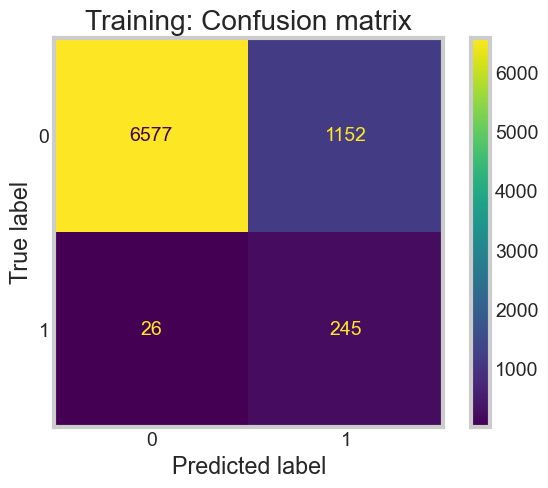

In [62]:
from sklearn.metrics import ConfusionMatrixDisplay

model = pipe_imbalanced.fit(xtrain, ytrain)
ConfusionMatrixDisplay.from_estimator(model, xtrain, ytrain, display_labels=[0, 1])
plt.grid(False)
plt.title('Training: Confusion matrix')
plt.show()

In [63]:
print(f'roc_auc training: {roc_auc_score(ytrain, pipe_imbalanced.predict(xtrain))}')

roc_auc training: 0.8775050022462962


In [64]:
ypred = pipe_imbalanced.predict(xtest.values)

In [65]:
print(classification_report_imbalanced(ytest, ypred))

                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.85      0.90      0.92      0.87      0.76      1932
          1       0.18      0.90      0.85      0.29      0.87      0.77        68

avg / total       0.97      0.85      0.90      0.90      0.87      0.76      2000



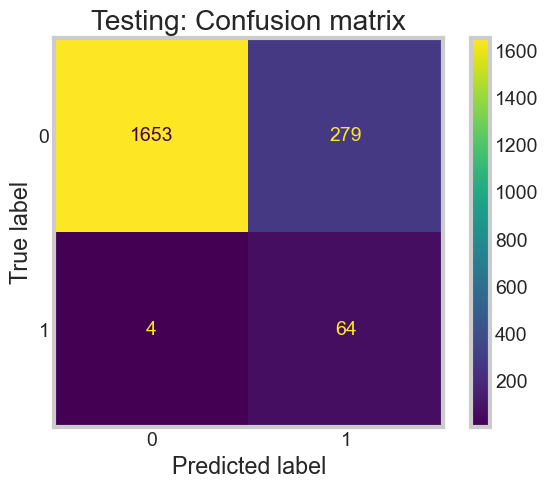

In [109]:
from sklearn.metrics import ConfusionMatrixDisplay

model = pipe_imbalanced.fit(xtest, ytest)
ConfusionMatrixDisplay.from_estimator(model, xtest, ytest, display_labels=[0, 1])
plt.grid(False)
plt.title('Testing: Confusion matrix')
plt.show()

In [67]:
print(f'roc_auc test: {roc_auc_score(ytest, pipe_imbalanced.predict(xtest))}')

roc_auc test: 0.8983832663500183


In [68]:
failure_data = maintenance[maintenance['Failure Type'] != 'No Failure']

In [69]:
fdata = failure_data[cols_selected]
ftarget = failure_data['Failure Type']

In [70]:
print(f'failure data shape: {fdata.shape}. failure type target shape = {ftarget.shape}.')

failure data shape: (348, 3). failure type target shape = (348,).


In [72]:
#we convert 
ftarget = ftarget.astype("category")
ftarget = ftarget.cat.rename_categories([0, 1, 2, 3, 4])
ftarget = ftarget.astype('int')

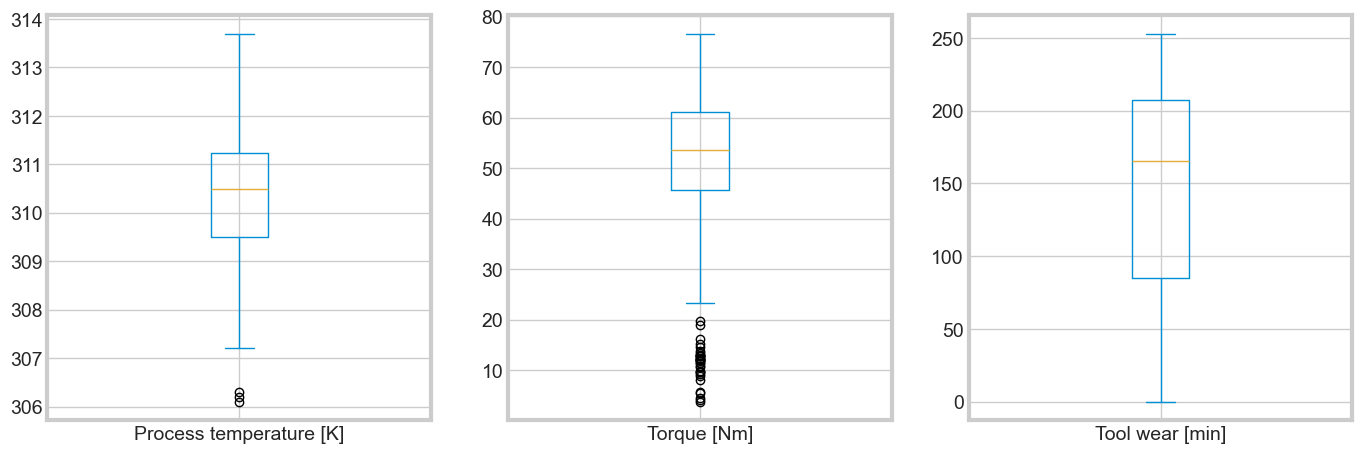

In [73]:
fdata.plot.box(subplots=True, figsize=(15,5))
plt.show()

In [75]:
#We split our data.
fxtrain, fxtest, fytrain, fytest = train_test_split(fdata, ftarget, stratify=ftarget, random_state=0,test_size=0.2)

In [78]:
from imblearn.ensemble import (
    BalancedBaggingClassifier,
    RUSBoostClassifier,
    BalancedRandomForestClassifier,
    EasyEnsembleClassifier
)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import cross_validate
from sklearn.tree import ExtraTreeClassifier
from imblearn.metrics import geometric_mean_score
import numpy as np

def best_enSamplerLearner(X, y):
    ens_learners = {
        'Balanced Bagging': BalancedBaggingClassifier(estimator=ExtraTreeClassifier(), random_state=0, n_jobs=-1),
        'RUS Boost': RUSBoostClassifier(estimator=ExtraTreeClassifier(), random_state=0),
        'Balanced RF': BalancedRandomForestClassifier(random_state=0, n_jobs=-1),
        'Easy Ensemble': EasyEnsembleClassifier(estimator=ExtraTreeClassifier(), random_state=0, n_jobs=-1)
    }

    results = {}

    print("Cross-validation Results (10-fold)")
    print("=" * 70)

    for name, learner in ens_learners.items():
        try:
            model = make_pipeline(RobustScaler(), learner)
            cv_results = cross_validate(
                model, X, y,
                cv=10,
                n_jobs=-1,
                return_train_score=False,
                return_estimator=True
            )

            gmeans = []
            for estimator in cv_results['estimator']:
                y_pred = estimator.predict(X)
                g = geometric_mean_score(y, y_pred)
                gmeans.append(g)

            mean_gmean = np.mean(gmeans)
            std_gmean = np.std(gmeans)

            results[name] = (mean_gmean, std_gmean)

            print(f"{name:<20} | G-Mean = {mean_gmean:.3f} ± {std_gmean:.3f}")

        except Exception as e:
            print(f"{name:<20} | ❌ Error: {e}")

    return results


In [79]:
best_enSamplerLearner(fxtrain, fytrain)

Cross-validation Results (10-fold)
Balanced Bagging     | G-Mean = 0.872 ± 0.023
RUS Boost            | G-Mean = 0.869 ± 0.023
Balanced RF          | G-Mean = 0.899 ± 0.013
Easy Ensemble        | G-Mean = 0.868 ± 0.008


{'Balanced Bagging': (0.8720134176001286, 0.023233862419551478),
 'RUS Boost': (0.8687446813110933, 0.022694559491629237),
 'Balanced RF': (0.8991012315989181, 0.012781915321601783),
 'Easy Ensemble': (0.8681029698522525, 0.007855085387714022)}

In [98]:
fparams = {'BRFC__n_estimators': [100, 200], 'BRFC__criterion': ["gini", 'entropy'],
          'BRFC__max_depth': [1, 2, 3, 4, 5, 6,7],
         'BRFC__max_features': ['sqrt','log2','None']}

In [99]:
imbal_pipe_failure_ = Pipeline([('scaler', RobustScaler()),
                            ('BRFC', BalancedRandomForestClassifier(n_jobs=-1, random_state=0))])

In [100]:
imbalanced_pipe_failure = Pipeline([('scaler', RobustScaler()),
                            ('BRFC', BalancedRandomForestClassifier(n_jobs=-1, random_state=0,
                                                                   criterion='entropy',max_depth=5,
                                                                   max_features='log2', n_estimators=100))])

In [101]:
imbalanced_pipe_failure.fit(fxtrain, fytrain)

Pipeline(steps=[('scaler', RobustScaler()),
                ('BRFC',
                 BalancedRandomForestClassifier(criterion='entropy',
                                                max_depth=5,
                                                max_features='log2', n_jobs=-1,
                                                random_state=0))])

In [102]:
print(f'Training G-mean = {geometric_mean_score(fytrain, imbalanced_pipe_failure.predict(fxtrain))}')

Training G-mean = 0.8801505065621668


In [103]:
print(classification_report_imbalanced(fytrain, imbalanced_pipe_failure.predict(fxtrain)))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.95      0.80      0.98      0.87      0.88      0.77        90
          1       0.78      0.98      0.92      0.87      0.95      0.91        62
          2       0.91      0.83      0.97      0.87      0.90      0.79        76
          3       0.86      0.86      0.99      0.86      0.92      0.84        14
          4       0.83      0.94      0.97      0.88      0.96      0.91        36

avg / total       0.88      0.87      0.96      0.87      0.91      0.83       278



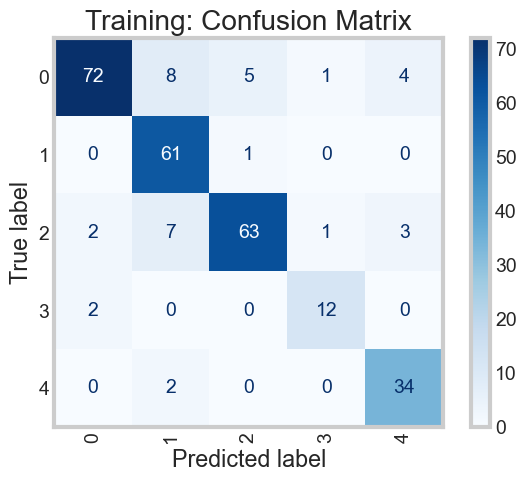

In [104]:
from sklearn.metrics import ConfusionMatrixDisplay

# Plotting the confusion matrix using the new method
ConfusionMatrixDisplay.from_estimator(
    imbalanced_pipe_failure,
    fxtrain,
    fytrain,
    display_labels=[0, 1, 2, 3, 4],
    cmap='Blues',
    xticks_rotation='vertical'
)

plt.grid(False)
plt.title("Training: Confusion Matrix")
plt.show()


In [105]:
print(f'Test G-mean = {geometric_mean_score(fytest, imbalanced_pipe_failure.predict(fxtest))}')

Test G-mean = 0.7702581036802232


In [106]:
print(classification_report_imbalanced(fytest, imbalanced_pipe_failure.predict(fxtest)))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.89      0.73      0.96      0.80      0.83      0.68        22
          1       0.75      0.94      0.91      0.83      0.92      0.85        16
          2       0.94      0.89      0.98      0.92      0.94      0.87        19
          3       0.50      0.50      0.97      0.50      0.70      0.46         4
          4       0.80      0.89      0.97      0.84      0.93      0.85         9

avg / total       0.84      0.83      0.95      0.83      0.89      0.78        70



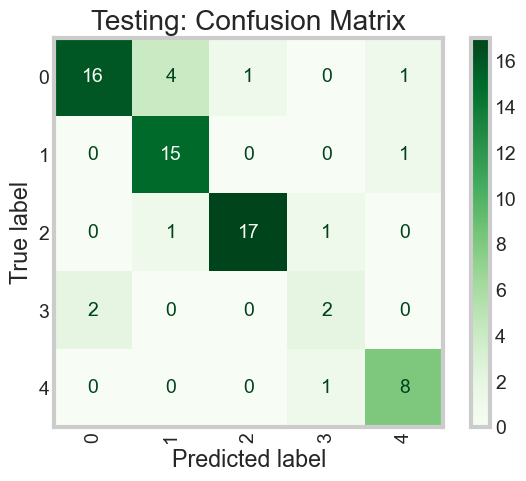

In [108]:
from sklearn.metrics import ConfusionMatrixDisplay

# Plotting the confusion matrix using the new method
ConfusionMatrixDisplay.from_estimator(
    imbalanced_pipe_failure,
    fxtest,
    fytest,
    display_labels=[0, 1, 2, 3, 4],
    cmap='Greens',
    xticks_rotation='vertical'
)

plt.grid(False)
plt.title("Testing: Confusion Matrix")
plt.show()

In [110]:
def MPM_model_decision(input_data=None):
    """
    input_data: 1d-dimensional array data
    
    return Failure and Failure Type
    """
    #
    failure_type = sorted(failure_data['Failure Type'].unique().tolist())
    ypred = pipe_imbalanced.predict(input_data)
    prob  = pipe_imbalanced.predict_proba(input_data)[0]
    if ypred == 0:
        print(f"Decision = {'No Failure'} with probability = {prob[ypred][0]}")
    else:
        y_pred = imbalanced_pipe_failure.predict(input_data)[0]
        prob   = imbalanced_pipe_failure.predict_proba(input_data)[0]
        print(f'Decision = {failure_type[y_pred]} with probability = {prob[y_pred]}')

In [111]:
print(f'Consider we have data: {np.array([[309.1 ,4.6,143]])}; the information of one product.')
MPM_model_decision(np.array([[309.1, 4.6, 143]]))

Consider we have data: [[309.1   4.6 143. ]]; the information of one product.
Decision = Power Failure with probability = 0.7041764705882353


In [112]:
print(f'Consider we have data: {np.array([[308.0,42.8,0.0]])}; the information of one product.')
MPM_model_decision(np.array([[308.0,42.8,0.0]]))

Consider we have data: [[308.   42.8   0. ]]; the information of one product.
Decision = No Failure with probability = 0.9619764161870673
